In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.preprocessing import MinMaxScaler









# df=pd.read_excel('beximco2000.xlsx')
# # df.loc[df['TRADEDATE'] > '22-09-1999']

# plt.figure(figsize=(18,9))
# plt.plot(range(df.shape[0]),df['CLSPRC'])
# plt.xticks(range(0,df.shape[0],500),df['TRADEDATE'].loc[::500],rotation=45)
# plt.xlabel('Date',fontsize=18)
# plt.ylabel('CLose price',fontsize=18)
# plt.show()

In [63]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

### LOAD DATA

In [64]:
df=pd.read_excel('beximco2000.xlsx')
# df.loc[df['TRADEDATE'] > '22-09-1999']
df['TRADEDATE']=pd.to_datetime(df['TRADEDATE'])
df.set_index('TRADEDATE', inplace=True)
df.head()


,COMID,LOWPRC,HIPRC,AVGPRC,CLSPRC,TRDNO,TRDVOL,TURNOVER,COMPANYNAME
TRADEDATE,,,,,,,,,
2000-07-15,453,78.5,82.0,79.63,78.7,2537,769775,61278365.0,BEXIMCO PHARMACEUTICALS LIMITED
2000-07-16,453,69.6,79.0,73.25,71.4,4590,1627125,118776810.0,BEXIMCO PHARMACEUTICALS LIMITED
2000-07-17,453,70.0,75.7,74.01,74.3,4489,1422375,105223510.0,BEXIMCO PHARMACEUTICALS LIMITED
2000-07-18,453,72.0,77.8,74.32,73.2,3985,1361275,101138340.0,BEXIMCO PHARMACEUTICALS LIMITED
2000-07-19,453,68.7,72.6,70.52,69.9,4899,1671075,117673305.0,BEXIMCO PHARMACEUTICALS LIMITED


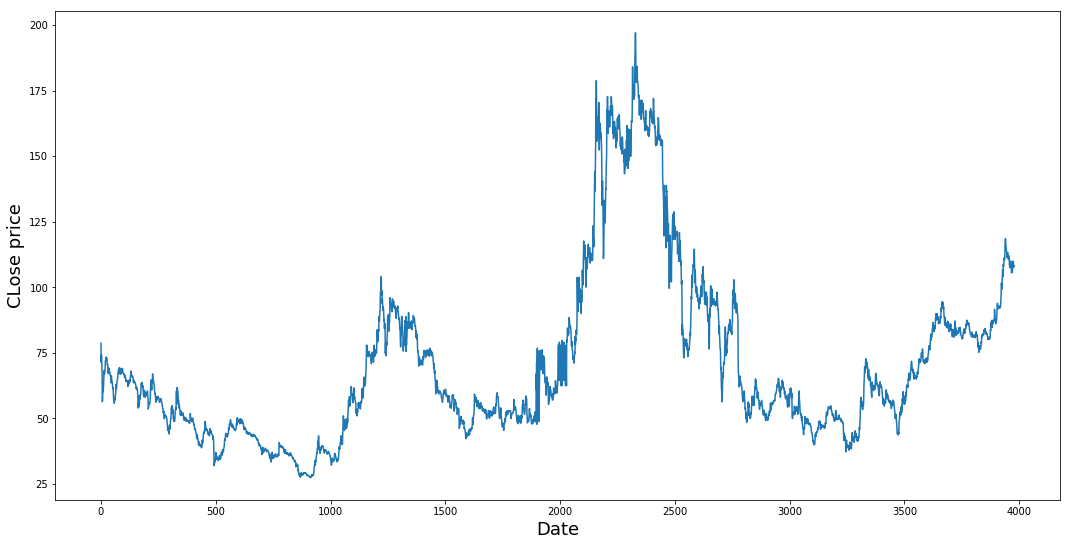

In [65]:
plt.figure(figsize=(18,9))
plt.plot(range(df.shape[0]),df['CLSPRC'])
# plt.xticks(range(0,df.shape[0],500),df[TRADEDATE].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('CLose price',fontsize=18)
plt.show()

In [66]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3979 entries, 2000-07-15 to 2017-05-31
Data columns (total 9 columns):
COMID          3979 non-null int64
LOWPRC         3979 non-null float64
HIPRC          3979 non-null float64
AVGPRC         3979 non-null float64
CLSPRC         3979 non-null float64
TRDNO          3979 non-null int64
TRDVOL         3979 non-null int64
TURNOVER       3979 non-null float64
COMPANYNAME    3979 non-null object
dtypes: float64(5), int64(3), object(1)
memory usage: 310.9+ KB


In [67]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['AVGPRC'] = min_max_scaler.fit_transform(df.AVGPRC.values.reshape(-1,1))
    df['HIPRC'] = min_max_scaler.fit_transform(df.HIPRC.values.reshape(-1,1))
    df['LOWPRC'] = min_max_scaler.fit_transform(df.LOWPRC.values.reshape(-1,1))
    df['CLSPRC'] = min_max_scaler.fit_transform(df['CLSPRC'].values.reshape(-1,1))
    return df


In [68]:
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [69]:
df_stock=df.copy()
df_stock.drop(['COMID'],1,inplace=True)
# df_stock.drop(['COMID'],1,inplace=True)

df_stock.drop(['TRDNO'],1,inplace=True)
df_stock.drop(['TRDVOL'],1,inplace=True)
df_stock.drop(['TURNOVER'],1,inplace=True)
df_stock.drop(['COMPANYNAME'],1,inplace=True)











cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

df_stock.columns.values =  ['LOWPRC', 'HIPRC', 'AVGPRC', 'CLSPRC']


In [70]:
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)




In [71]:
# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3167, 19, 4)
y_train.shape =  (3167, 4)
x_valid.shape =  (396, 19, 4)
y_valid.shape =  (396, 4)
x_test.shape =  (396, 19, 4)
y_test.shape =  (396, 4)


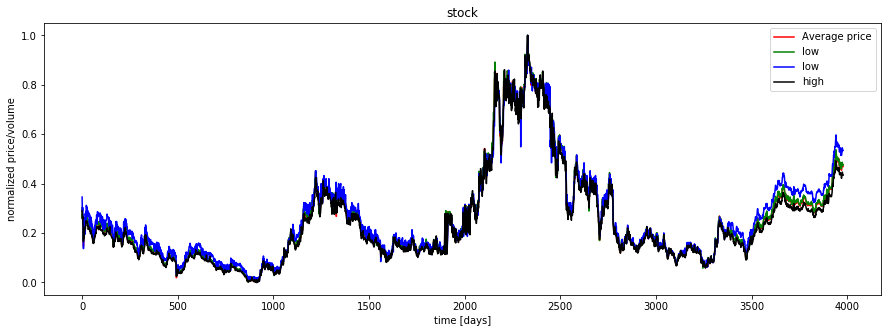

In [72]:


plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.AVGPRC.values, color='red', label='Average price')
plt.plot(df_stock_norm.CLSPRC.values, color='green', label='low')
plt.plot(df_stock_norm.LOWPRC.values, color='blue', label='low')
plt.plot(df_stock_norm.HIPRC.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()



In [73]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.776757/0.626512
4.99 epochs: MSE train/valid = 0.000458/0.000158
9.98 epochs: MSE train/valid = 0.000303/0.000086
14.97 epochs: MSE train/valid = 0.000290/0.000078
19.96 epochs: MSE train/valid = 0.000263/0.000062
24.94 epochs: MSE train/valid = 0.000278/0.000077
29.93 epochs: MSE train/valid = 0.000244/0.000065
34.92 epochs: MSE train/valid = 0.000246/0.000055
39.91 epochs: MSE train/valid = 0.000248/0.000056
44.90 epochs: MSE train/valid = 0.000241/0.000058
49.89 epochs: MSE train/valid = 0.000249/0.000081
54.88 epochs: MSE train/valid = 0.000251/0.000054
59.87 epochs: MSE train/valid = 0.000279/0.000066
64.86 epochs: MSE train/valid = 0.000286/0.000088
69.85 epochs: MSE train/valid = 0.000239/0.000052
74.83 epochs: MSE train/valid = 0.000262/0.000075
79.82 epochs: MSE train/valid = 0.000304/0.000083
84.81 epochs: MSE train/valid = 0.000246/0.000067
89.80 epochs: MSE train/valid = 0.000220/0.000051
94.79 epochs: MSE train/valid = 0.000242/0.000062
99.

In [76]:
y_test_pred.shape

(396, 4)

correct sign prediction for close - open price for train/valid/test: 0.87/0.88/1.00


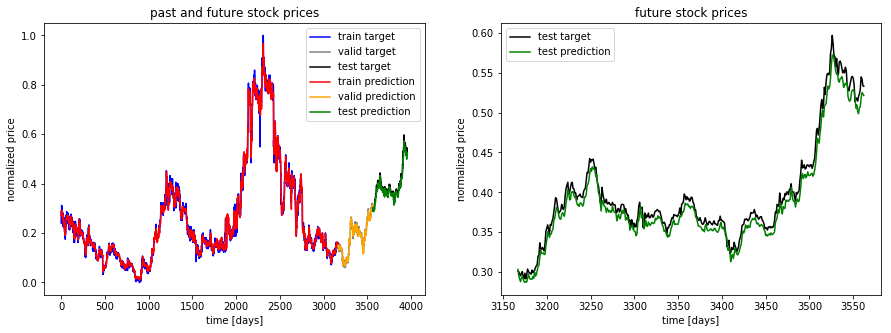

In [77]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

In [84]:
np.mean(((y_test-y_test_pred)**2)/y_test)

0.00026353388197489919